In [3]:
import pymc as pm
import arviz as az
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

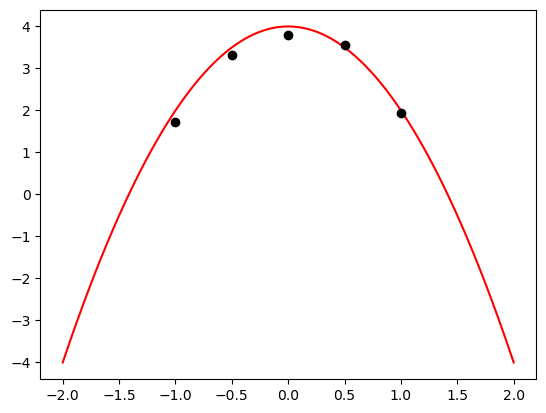

In [4]:
# Simulate data.
RANDOM_SEED = 10 
rng = np.random.default_rng(RANDOM_SEED)

# True function. 
g = lambda x : 4 - 2*np.power(x,2)

sig = 0.25 
n_design = 5
n_test = 100
X_design = np.linspace(-1, 1, num=n_design)[:, None]
X_test = np.linspace(-2, 2, num=n_test)[:, None]
g_test = g(X_test)
y_design = g(X_design)[:,0] + rng.normal(loc=0, scale=sig, size=n_design)

plt.plot(X_test, g_test, "r")
plt.plot(X_design, y_design, "ko")
plt.show()

# sig = 0.25
# par_true = 1.0
# n_obs = 10
# time_steps = np.linspace(start=0, stop=10, num=400)
# time_steps_obs = np.linspace(start=0, stop=10, num=n_obs)
# g_dense = lambda u : u * np.cos(np.pi*time_steps/2)
# g = lambda u : u * np.cos(np.pi*time_steps_obs/2)
# g_true_dense = g_dense(par_true)
# g_true = g(par_true)
# y = g_true + rng.normal(loc=0, scale=sig, size=n_obs)

# plt.plot(time_steps, g_true_dense)
# plt.plot(time_steps_obs, y, "ro")
# plt.show()


# Investigating the Gaussian Kernel. 
Suppose inputs are scaled so that $x \in [0,1]$. PyMC parameterizes the Gaussian kernel as 
$$
k(r) = \exp\left[-\frac{1}{2}\left(\frac{r}{\ell}\right)^2 \right].
$$

We start by fixing the maximum distance of $r=1$, and vary the lengthscale $\ell$ to see how the correlation $k(1)$ changes with the lengthscale at the largest possible pairwise distance. 

In [29]:
test = pm.gp.cov.ExpQuad(1, ls=1)
test(np.array(1.0).reshape(1,1)).eval()

array([[1.]])

In [26]:
cov_func(X_design).cast(x, 'float32')

AttributeError: 'TensorVariable' object has no attribute 'cast'

In [40]:
[x for x in range(-8, 0)]

[-8, -7, -6, -5, -4, -3, -2, -1]

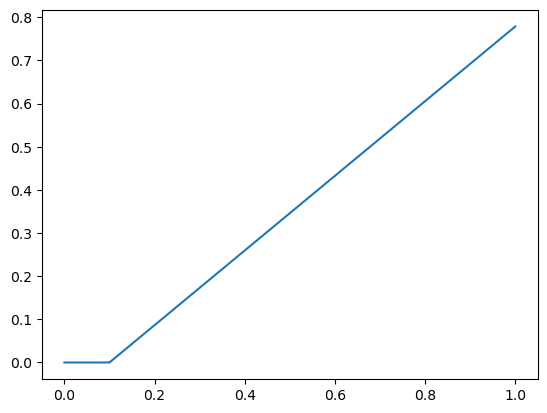

In [42]:
k = lambda r, ell : np.exp(-0.5 * (r/ell)**2) 

ell_grid = [10**k for k in range(-8, 1)]
corr_grid = [k(1,ell) for ell in ell_grid]

plt.plot(ell_grid, corr_grid)
plt.show()

In [9]:
# Define GP mean/covariance functions. 

# Kernel. 
ell_true = 1.0
eta_true = 4.0
alpha = 1.0
cov_func = alpha**2 * pm.gp.cov.Polynomial(1, c=3, d=2, offset=0)

# cov_func = eta_true**2 * (pm.gp.cov.ExpQuad(1, ell_true) + pm.gp.cov.Polynomial(1, 0, 2, 1))

# Mean function. 
mean_func = pm.gp.mean.Zero()

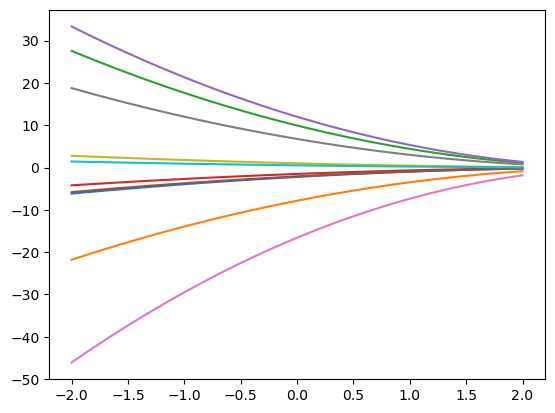

In [10]:
# Sample from GP prior. 
prior_draws = pm.draw(pm.MvNormal.dist(mu=mean_func(X_test), cov=cov_func(X_test)), 10, random_seed=rng)

plt.plot(X_test, np.transpose(prior_draws))
plt.show()

In [6]:
# Fit hyperparameters. Note that the marginal GP model 
# simply means a GP with Gaussian noise, so that the GP 
# can be analytically marginalized. The latent GP implementation 
# is more of a standalone GP that can be incorporated into other 
# likelihoods, etc. 

with pm.Model() as marginal_gp_model:
    # Offset constant in polynomial kernel.
    offset_cst = pm.Uniform("offset", lower=0, upper=10)
    
    # Covariance. 
    cov_func = pm.gp.cov.Polynomial(1, c=0, d=2, offset=offset_cst)

    # Mean function. 
    mean_func = pm.gp.mean.Zero()

    # Specify the GP..
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Fix the observation noise. This can alternatively be assigned a prior.  
    sigma = sig # pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X_design, y=y_design, sigma=sigma)

    # Predict. Don't think this needs to be within the "with" environment. 
    # mu, Cov = gp.predict(Xnew=X_test)

    # Alternatively, we can form the conditional GP which can then be used for prediction. 
    # This object can then be used in posterior predictive sampling, etc. 
    # gp_cond = gp.conditional("gp_cond", Xnew=X_test, pred_noise=False)

with pm.Model() as model_fixed_hyperpars:
    # Offset constant in polynomial kernel.
    offset_cst = 1
    
    # Covariance. 
    cov_func = pm.gp.cov.Polynomial(1, c=0, d=2, offset=offset_cst)

    # Mean function. 
    mean_func = pm.gp.mean.Zero()

    # Specify the GP..
    gp2 = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    
    # Fix the observation noise. This can alternatively be assigned a prior.  
    sigma = sig # pm.HalfCauchy("sigma", beta=5)

    # Construct the Gaussian random variable representing the observation process y = f + eps. 
    y_ = gp2.marginal_likelihood("y_process", X=X_design, y=y_design, sigma=sigma)

    # GP Predictions. 
    

    # GP conditional. 
    # nu2, mu, cov = gp2._build_conditional(X_test_extrapolate, X_design, y_design, 1e-06)
    
    # pred = gp2.conditional("gp_cond", Xnew=X_test_extrapolate)


In [29]:
# GP with fixed hyperparameters. 
# Helpful resource on predicting with GPs: https://discourse.pymc.io/t/predicting-on-new-data-with-gp-conditional/6229/3
# Helpful for GP prediction: https://discourse.pymc.io/t/how-to-use-a-tensorvariable-in-gp-predict-method/12766

X_test_extrapolate = np.linspace(-10, 10, num=200)[:, None]
g_test_extrapolate = g(X_test_extrapolate)

with model_fixed_hyperpars:
    pred = gp2.predict(Xnew=X_test_extrapolate)

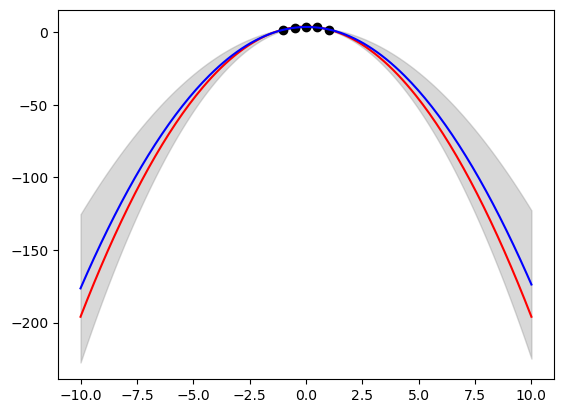

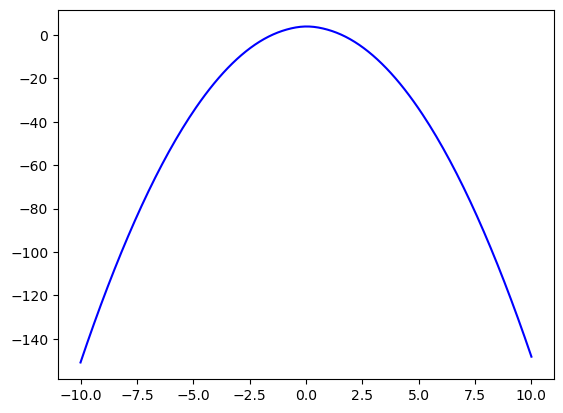

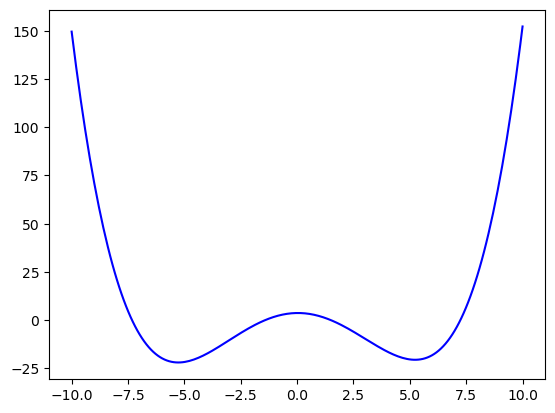

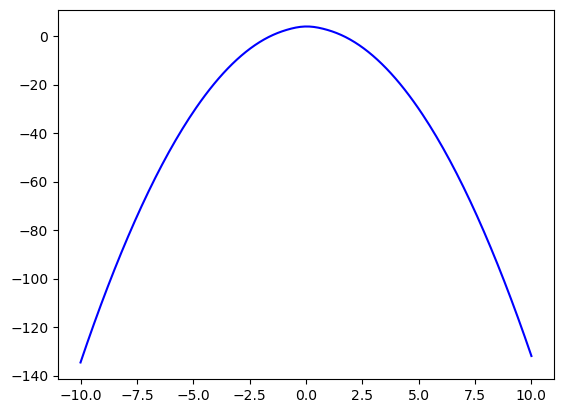

In [35]:
# Plot predictions. 

pred_mean = pred[0]
pred_sd = np.sqrt(np.diag(pred[1]))

# Prediction plot. 
plt.plot(X_test_extrapolate, g_test_extrapolate, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test_extrapolate, pred_mean, "b")
plt.fill_between(X_test_extrapolate[:,0], pred_mean-2*pred_sd, pred_mean+2*pred_sd, color="gray", alpha=0.3)
plt.show()

# Mean plus standard deviation.  
plt.plot(X_test_extrapolate, pred_mean + pred_sd, "b")
plt.show()

# Mean plus 0.5*variance (as in the GP marginal approximate posterior).   
plt.plot(X_test_extrapolate, pred_mean + 0.5*np.power(pred_sd, 2), "b")
plt.show()

# Mean plus 1.64*sd (as in the GP quantile approximate posterior with alpha=0.05).   
plt.plot(X_test_extrapolate, pred_mean + 1.64*pred_sd, "b")
plt.show()

In [7]:
# Sample from the posterior over GP hyperparameters. 

with marginal_gp_model: 
    marginal_post = pm.sample(500, tune=2000, nuts_sampler="numpyro", chains=1)

/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sample: 100%|███████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1064.20it/s, 5 steps of size 5.39e-01. acc. prob=0.92]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
summary = az.summary(marginal_post, var_names=["offset"], round_to=2, kind="stats")
summary

,mean,sd,hdi_3%,hdi_97%
offset,5.24,2.27,2.02,9.45


array([[<Axes: title={'center': 'offset'}>,
        <Axes: title={'center': 'offset'}>]], dtype=object)

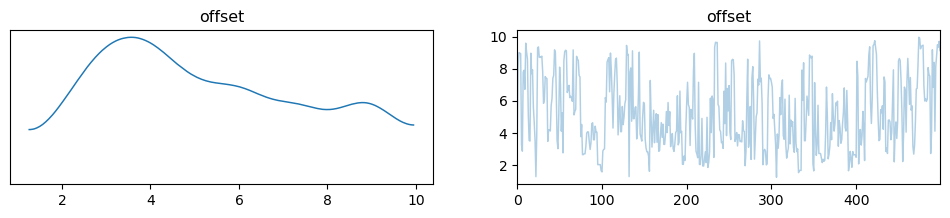

In [9]:
az.plot_trace(marginal_post)

In [11]:
# Sample predictive distribution. 
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_test)

with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0, 20)), var_names=["f_pred"]
    )

Sampling: [f_pred]


/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

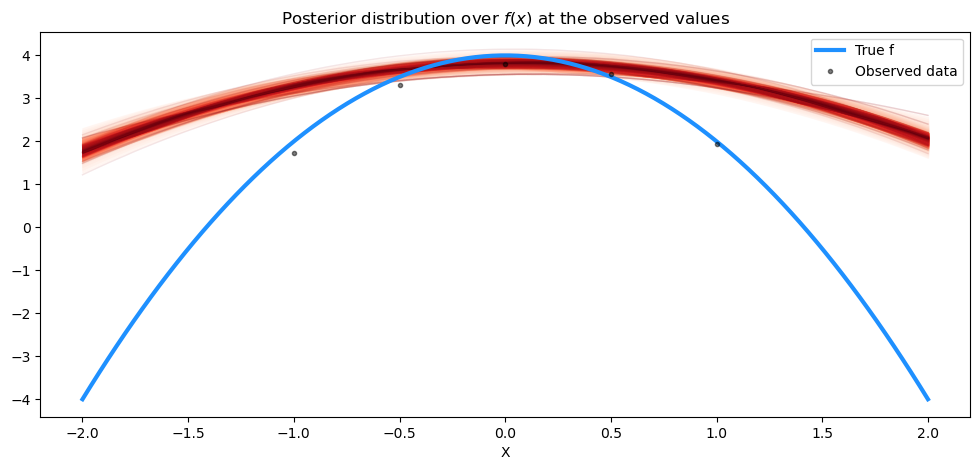

In [14]:
# Plot predictive GP samples. 

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_pred_samples = az.extract(pred_samples, group="posterior_predictive", var_names=["f_pred"])
plot_gp_dist(ax, samples=f_pred_samples.T, x=X_test)

# plot the data and the true latent function
plt.plot(X_test, g_test, "dodgerblue", lw=3, label="True f")
plt.plot(X_design, y_design, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
# plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [6]:
# Attributes of model object. 
print(marginal_gp_model.basic_RVs)
print(marginal_gp_model.unobserved_RVs)
print(marginal_gp_model.value_vars)

# Appears that objects created in the "with" environment are available as global variables. 
print(type(gp))
print(type(gp_cond))

[gp_cond, y]
[gp_cond]
[gp_cond]
<class 'pymc.gp.gp.Marginal'>
<class 'pytensor.tensor.variable.TensorVariable'>


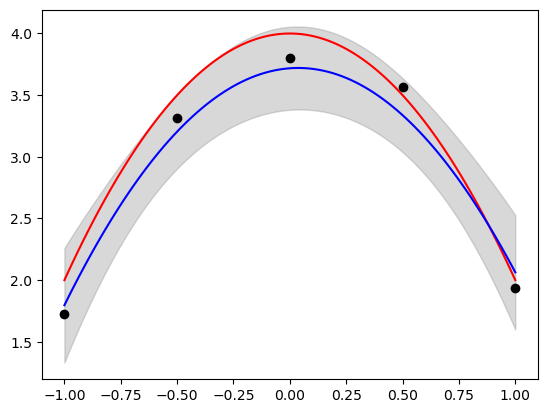

In [7]:
pred_vars = np.sqrt(np.diag(Cov))

plt.plot(X_test, g_test, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test, mu, "b")
plt.fill_between(X_test[:,0], mu-2*pred_vars, mu+2*pred_vars, color="gray", alpha=0.3)
plt.show()

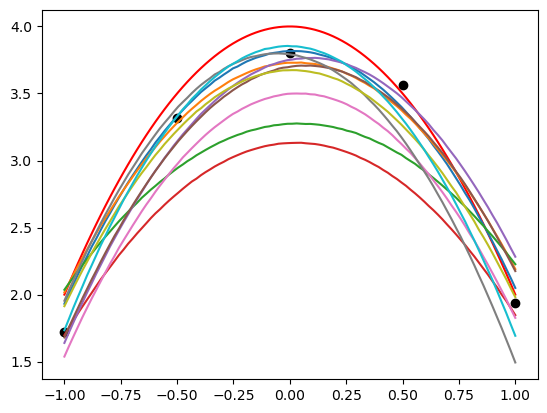

In [8]:
# Sample from GP conditional. 
cond_draws = pm.draw(pm.MvNormal.dist(mu=mu, cov=Cov), 10, random_seed=rng)

plt.plot(X_test, g_test, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test, np.transpose(cond_draws))
plt.show()

In [109]:
# Predict on test points. Use `pred_noise` argument to specify whether to add noise 
# variance to predictions or not. 

# with marginal_gp_model:
#     

mu, Cov = pm.gp.Marginal.predict(X_test, model=marginal_gp_model)


TypeError: Marginal.predict() missing 1 required positional argument: 'Xnew'